# Phase Fixed Amplitude Posterior Drawer

-   Draw the phase-fixed analysis results.


## Setup

### Import

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

from iminuit import Minuit

import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

from FigureSetting import set_nature_style, mm_to_inches, colors, color_blur

### Figure Setting

In [2]:
set_nature_style()
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

figsize = (180 * mm_to_inches, 120 * mm_to_inches)
plt.rcParams['figure.figsize'] = figsize

figure_dir = "../figure/"
figure_name = "PhaseFixedPosterior.pdf"
figure_path = figure_dir + figure_name


## Read Data

In [3]:
dama_amplitude = {  # [dru]
    "2-6": (0.00996, 0.00074),
    "1-6": (0.01048, 0.00090),
    "1-3": (0.0191, 0.0020),
}


In [4]:
configurations = [  # [policy, energy_range]
    ("erc", "1-3"),
    ("nrc", "2-6"),
    ("erc", "1-6"),
    ("erc", "2-6"),
]

configuration_titles = {
    ("nrc", "2-6"): r"6.7-20$\mathrm{\,keV_{nr}}$",
    ("erc", "1-3"): r"1-3$\mathrm{\,keV_{ee}}$",
    ("erc", "1-6"): r"1-6$\mathrm{\,keV_{ee}}$",
    ("erc", "2-6"): r"2-6$\mathrm{\,keV_{ee}}$",
}
tick_widths = {
    ("nrc", "2-6"): 0.005,
    ("erc", "1-3"): 0.01,
    ("erc", "1-6"): 0.005,
    ("erc", "2-6"): 0.005,
}


In [5]:
public_data_dir = "../data/"
posterior_path_format = public_data_dir + "AmplitudePosterior_{policy}{energy_range}.csv"
pseudo_path_format = public_data_dir + "PseudoUnderDama_{policy}{energy_range}.csv"


In [6]:
posterior_dfs = {
    configuration: pd.read_csv(
        posterior_path_format.format(
            policy=configuration[0], energy_range=configuration[1]
        )
    )
    for configuration in configurations
}
pseudo_dfs = {
    configuration: pd.read_csv(
        pseudo_path_format.format(
            policy=configuration[0], energy_range=configuration[1]
        )
    )
    for configuration in configurations
}


In [7]:
posterior_dfs[("erc", "1-3")].head()

,amplitude,mcmc_samples
0,-0.076381,0
1,-0.076343,0
2,-0.076304,0
3,-0.076266,0
4,-0.076228,0


In [8]:
pseudo_dfs[("erc", "1-3")].head()

,amplitude_median,pseudo_experiments
0,-0.005101,1
1,-0.004632,1
2,-0.004164,2
3,-0.003695,1
4,-0.003227,2


## Preprocess

In [9]:
def histogram_to_pdf(counts, bin_centers):
    bin_width = bin_centers[1] - bin_centers[0]
    pdf = counts / np.sum(counts) / bin_width
    return pdf


In [10]:
posteriors = dict()
pseudos = dict()
for configuration in configurations:
    # Measurement posterior
    bin_centers = posterior_dfs[configuration]["amplitude"].values
    counts = posterior_dfs[configuration]["mcmc_samples"].values
    width = bin_centers[1] - bin_centers[0]
    pdf = counts / np.sum(counts) / width

    posteriors[configuration] = (bin_centers, pdf)

    # Pseudo-experiment distribution
    bin_centers = pseudo_dfs[configuration]["amplitude_median"].values
    counts = pseudo_dfs[configuration]["pseudo_experiments"].values
    width = bin_centers[1] - bin_centers[0]
    pdf = counts / np.sum(counts) / width
    pdf_error = np.sqrt(counts) / np.sum(counts) / width

    pseudos[configuration] = (bin_centers, pdf, pdf_error)


In [11]:
credible_sigma = np.array([-3, -2, -1, 0, 1, 2, 3])
credible_linestyles = [
    "dotted",
    "dashdot",
    "dashed",
    "solid",
    "dashed",
    "dashdot",
    "dotted",
]
credible_alphas = np.array([0.04, 0.08, 0.12, 0.12, 0.08, 0.04])

pseudo_credible_intervals = dict()
pseudo_std = dict()
for configuration in configurations:
    # Pseudo-experiment distribution
    bin_centers = pseudo_dfs[configuration]["amplitude_median"].values
    counts = pseudo_dfs[configuration]["pseudo_experiments"].values

    # fit std
    normalizer = np.sum(counts) * (bin_centers[1] - bin_centers[0])
    mu = dama_amplitude[configuration[1]][0]

    def llh(std):
        return np.sum(
            (counts - normalizer * norm.pdf(bin_centers, mu, std)) ** 2
        )

    m = Minuit(llh, std=0.1 * mu)
    m.migrad()
    std = m.values["std"]
    std_err = m.errors["std"]

    pseudo_credible_intervals[configuration] = mu + std * credible_sigma
    pseudo_std[configuration] = (std, std_err)

posterior_medians = dict()
posterior_credible_intervals = dict()
for configuration in configurations:
    # Measurement posterior
    bin_centers = posterior_dfs[configuration]["amplitude"].values
    counts = posterior_dfs[configuration]["mcmc_samples"].values
    width = bin_centers[1] - bin_centers[0]
    bins = np.concatenate(
        [bin_centers - width / 2, [bin_centers[-1] + width / 2]]
    )

    cdf = np.cumsum(counts) / np.sum(counts)
    posterior_medians[configuration] = np.interp(0.5, cdf, bins[1:])

    posterior_credible_intervals[configuration] = np.interp(
        norm.cdf(credible_sigma), cdf, bins[1:]
    )


## Draw Plot

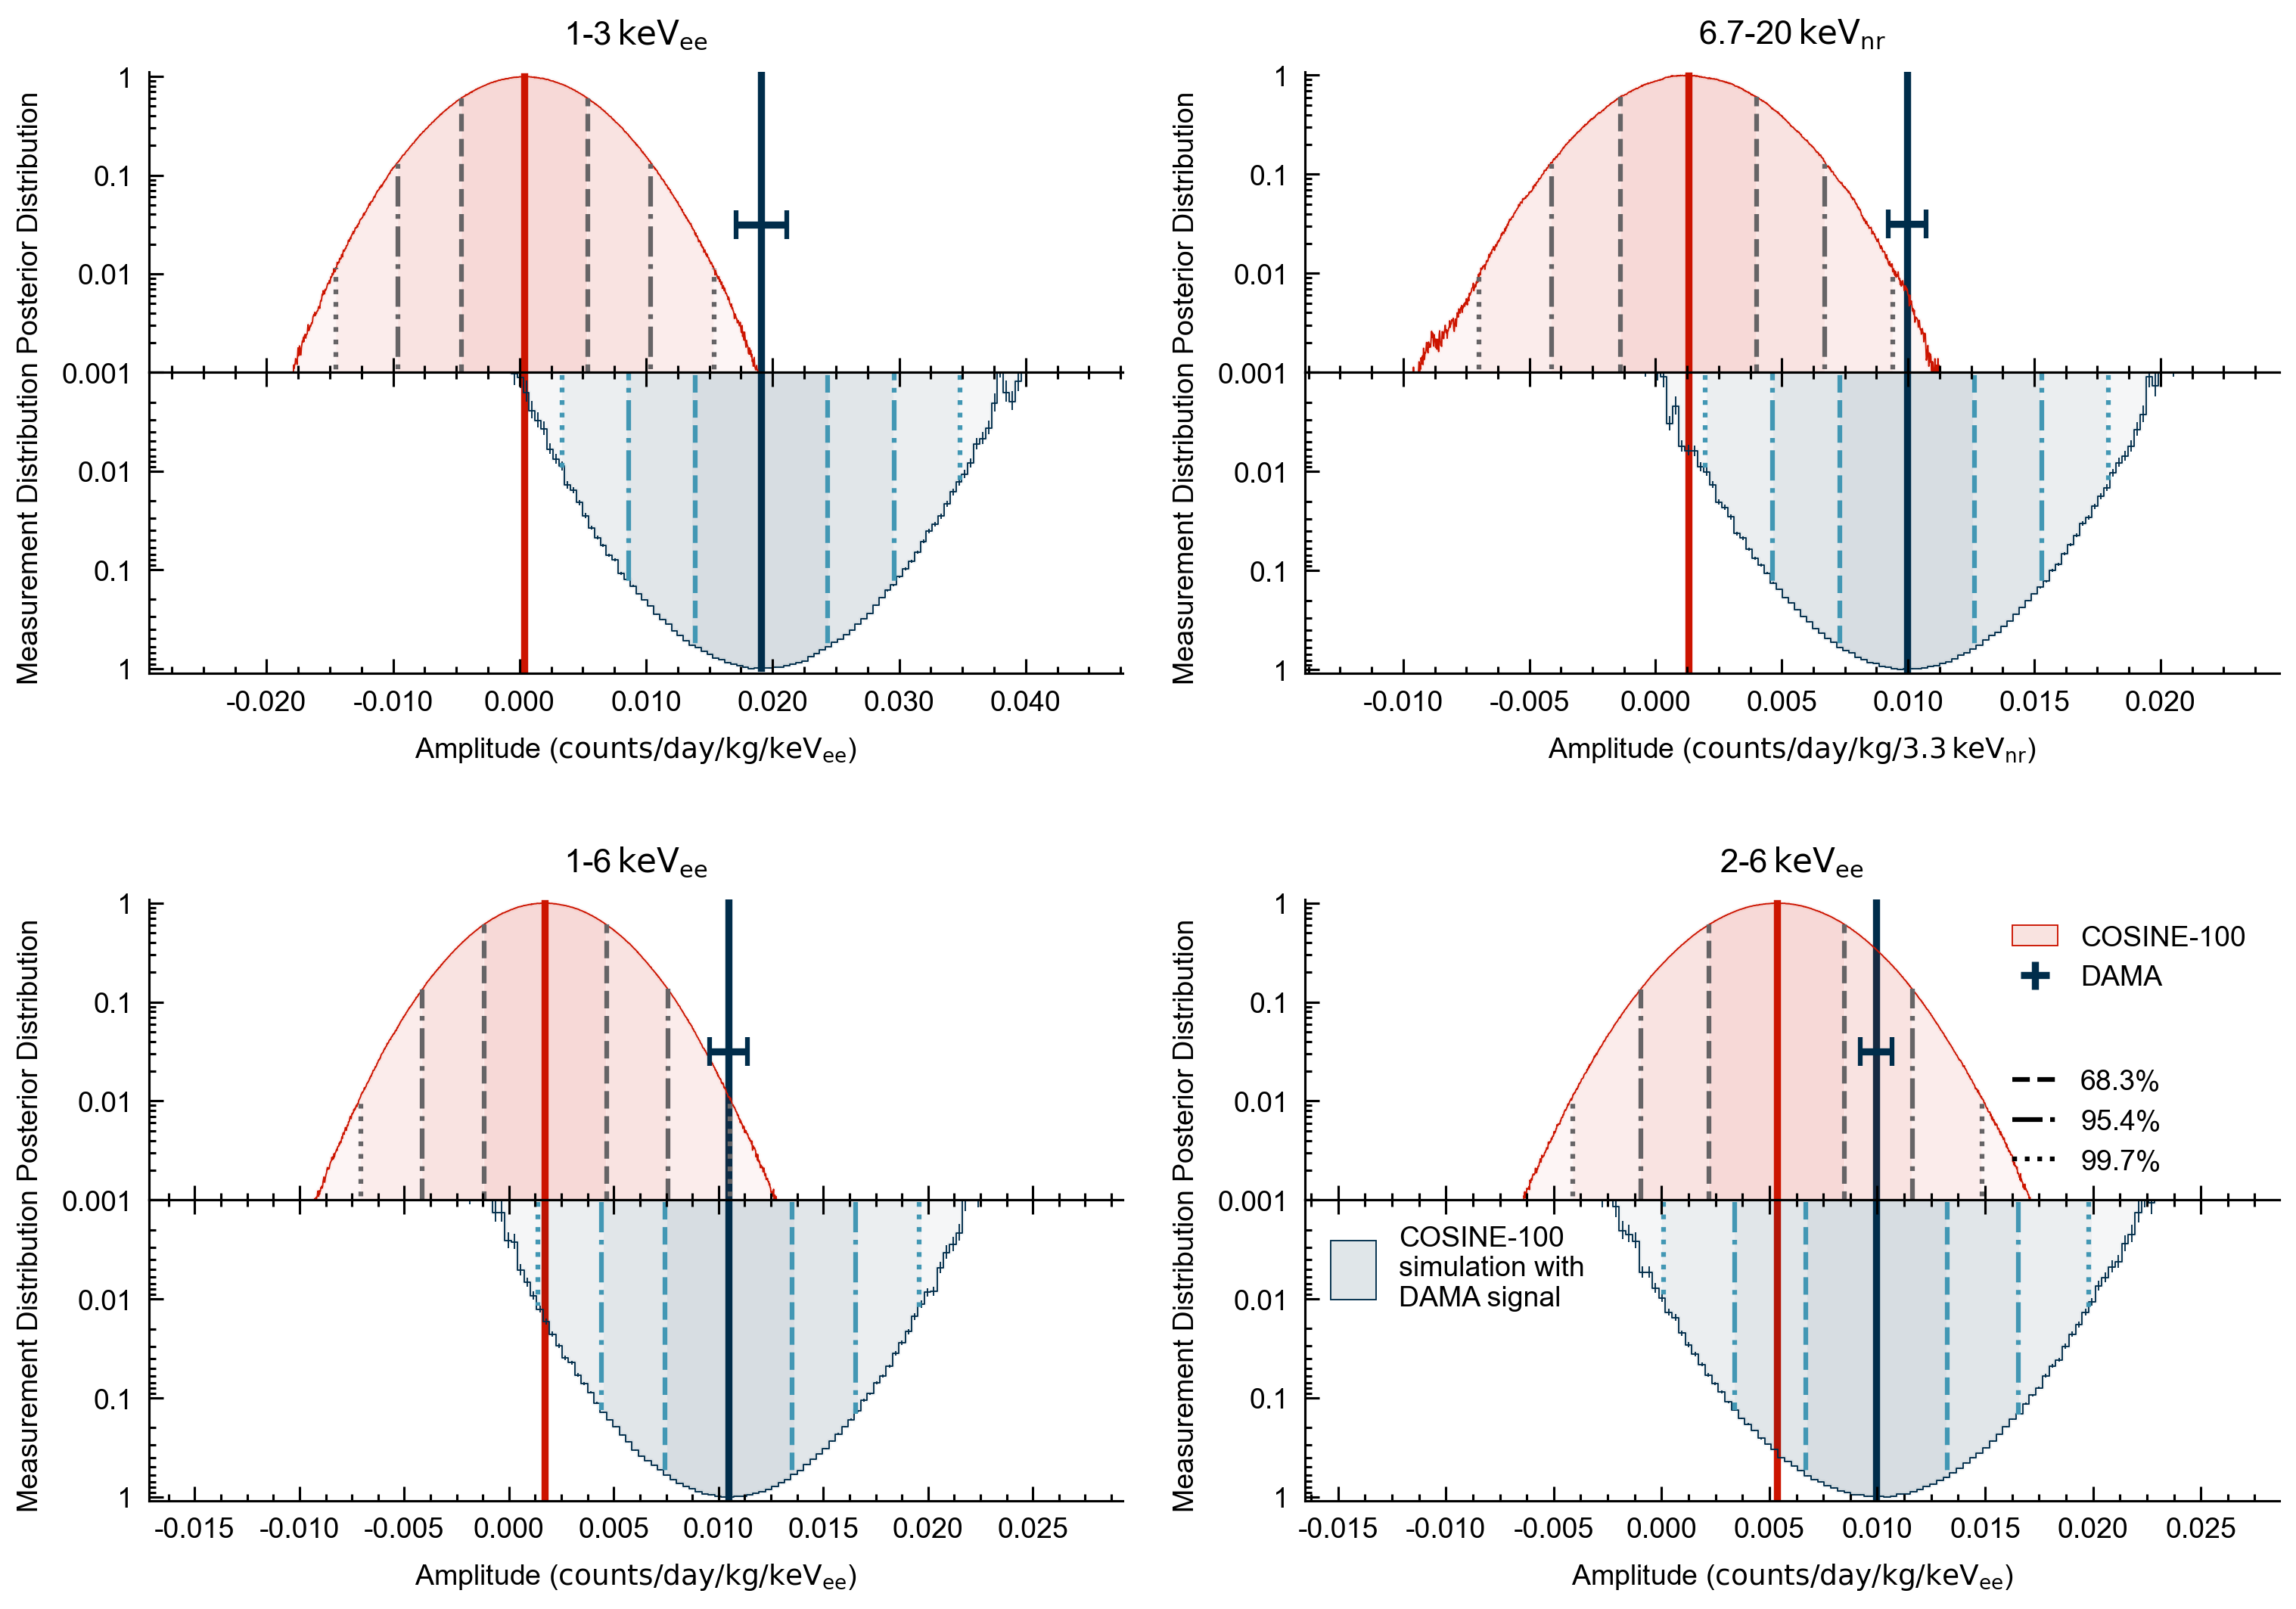

In [ ]:
fig = plt.figure()
config_figs = fig.subfigures(2, 2, wspace=-0.08, hspace=0.06)

items = zip(config_figs.flatten(), configurations)
for config_fig, configuration in items:
    ax_posterior, ax_measurement = config_fig.subplots(2, 1, sharex=True)
    ax_measurement.invert_yaxis()
    config_fig.subplots_adjust(hspace=0.0)

    posterior = posteriors[configuration]
    pseudo = pseudos[configuration]
    posterior_median = posterior_medians[configuration]
    pseudo_ci = pseudo_credible_intervals[configuration]

    # COSINE-100 posterior
    for x0, x1, alpha in zip(
        posterior_credible_intervals[configuration][:-1],
        posterior_credible_intervals[configuration][1:],
        credible_alphas,
    ):
        x = posterior[0][(posterior[0] >= x0) & (posterior[0] < x1)]
        y = np.interp(x, posterior[0], posterior[1] / posterior[1].max())
        ax_posterior.fill_between(
            x,
            0,
            y,
            color=colors["IbsRed"],
            edgecolor=None,
            alpha=alpha,
            zorder=-100 + 20,
        )

    for a, ls in zip(
        posterior_credible_intervals[configuration], credible_linestyles
    ):
        h = np.interp(a, posterior[0], posterior[1] / posterior[1].max())
        ax_posterior.plot(
            [a, a],
            [0, h],
            color=colors["IbsRed"] if ls == "solid" else colors["IbsGrey"],
            linestyle=ls,
            linewidth=1.5 if ls == "solid" else 1.0,
            zorder=-100 + 21,
        )
    ax_measurement.axvline(
        posterior_median,
        color=colors["IbsRed"],
        linestyle="solid",
        linewidth=1.5,
        zorder=-100 + -50,
    )

    ax_posterior.plot(
        posterior[0],
        posterior[1] / posterior[1].max(),
        color=colors["IbsRed"],
        linewidth=0.3,
        zorder=-100 + 20,
    )
    ax_posterior.fill_between(
        posterior[0],
        posterior[1] / posterior[1].max(),
        color=colors["IbsRed"],
        alpha=credible_alphas[-1],
        zorder=-100 + 18,
    )

    # Expected best-fit distribution under DAMA signal
    for x0, x1, alpha in zip(pseudo_ci[:-1], pseudo_ci[1:], credible_alphas):
        x_idx_min = np.argmin(np.abs(pseudo[0] - x0))
        x_idx_max = np.argmin(np.abs(pseudo[0] - x1)) + 1
        x = pseudo[0][x_idx_min:x_idx_max]
        y = np.interp(x, pseudo[0], pseudo[1] / pseudo[1].max())
        ax_measurement.fill_between(
            x,
            0,
            y,
            color=colors["InfnDeepBlue"],
            edgecolor=None,
            step="mid",
            alpha=alpha,
            zorder=-100 + 29,
        )

    for a, ls in zip(pseudo_ci, credible_linestyles):
        h = np.interp(a, pseudo[0], pseudo[1] / pseudo[1].max())
        ax_measurement.plot(
            [a, a],
            [0, h],
            color=(
                colors["InfnDeepBlue"] if ls == "solid" else colors["InfnBlue"]
            ),
            linestyle=ls,
            linewidth=1.5 if ls == "solid" else 1.0,
            zorder=-100 + 32,
        )
    ax_posterior.errorbar(
        dama_amplitude[configuration[1]][0],
        10 ** (-1.5),
        xerr=dama_amplitude[configuration[1]][1],
        marker=",",
        elinewidth=1.5,
        capsize=3,
        capthick=1.0,
        color=colors["InfnDeepBlue"],
    )
    ax_posterior.axvline(
        dama_amplitude[configuration[1]][0],
        color=colors["InfnDeepBlue"],
        linestyle="solid",
        linewidth=1.5,
        zorder=-100 + -50,
    )

    ax_measurement.step(
        pseudo[0],
        pseudo[1] / pseudo[1].max(),
        where="mid",
        linewidth=0.3,
        color=colors["InfnDeepBlue"],
        zorder=-100 + 30,
    )
    ax_measurement.errorbar(
        pseudo[0],
        pseudo[1] / pseudo[1].max(),
        pseudo[2] / pseudo[1].max(),
        fmt=",",
        elinewidth=0.3,
        color=colors["InfnDeepBlue"],
        zorder=-100 + 31,
    )
    ax_measurement.fill_between(
        pseudo[0],
        pseudo[1] / pseudo[1].max(),
        step="mid",
        color=colors["InfnDeepBlue"],
        alpha=credible_alphas[-1],
        zorder=-100 + 28,
    )

    # style
    # set y axis
    ax_posterior.set_yscale("log")
    ax_posterior.set_ylim(
        1.0e-3,
        (pseudo[1] + np.sqrt(pseudo[1])).max() / pseudo[1].max(),
    )
    ax_posterior.set_yticks([1.0e-3, 1.0e-2, 1.0e-1, 1.0])
    ax_posterior.set_yticklabels(["0.001", "0.01", "0.1", "1"])
    ax_measurement.set_yscale("log")
    ax_measurement.set_ylim(
        (pseudo[1] + np.sqrt(pseudo[1])).max() / pseudo[1].max(), 1.0e-3
    )
    ax_measurement.set_yticks([1.0, 1.0e-1, 1.0e-2, 1.0e-3])
    ax_measurement.set_yticklabels(["1", "0.1", "0.01", "0.001"])
    ax_posterior.get_yticklabels()[0].set_color((0, 0, 0, 0))  # transparent

    ax_posterior.set_ylabel("Posterior Distribution")
    ax_measurement.set_ylabel("Measurement Distribution")

    # set x axis
    x_min = min(
        np.min(posterior[0][posterior[1] > 0.0]),
        np.min(pseudo[0][pseudo[1] > 0.0]),
    )
    x_max = max(
        np.max(posterior[0][posterior[1] > 0.0]),
        np.max(pseudo[0][pseudo[1] > 0.0]),
    )
    x_width = x_max - x_min
    xlim = (x_min - 0.1 * x_width, x_max + 0.1 * x_width)

    ax_posterior.set_xlim(xlim)
    ax_measurement.set_xlim(xlim)

    xtick_width = tick_widths[configuration]
    xticks = np.arange(
        np.ceil(xlim[0] / xtick_width) * xtick_width,
        (np.floor(xlim[1] / xtick_width) + 0.1) * xtick_width,
        xtick_width,
    )
    ax_measurement.set_xticks(xticks)
    ax_measurement.set_xticklabels(["{:.3f}".format(x) for x in xticks])
    xticks_minor = np.arange(
        np.ceil(xlim[0] / (xtick_width / 4)) * xtick_width / 4,
        (np.floor(xlim[1] / (xtick_width / 4)) + 0.1) * xtick_width / 4,
        xtick_width / 4,
    )
    ax_measurement.set_xticks(xticks_minor, minor=True)

    ax_measurement.spines["top"].set_visible(True)
    ax_measurement.xaxis.set_tick_params(which="both", direction="in", top=True)

    if configuration[0] == "nrc":
        unit = r"($\mathrm{counts/day/kg/3.3 \, keV_{nr}}$)"
    else:
        unit = r"($\mathrm{counts/day/kg/keV_{ee}}$)"
    ax_measurement.set_xlabel("Amplitude " + unit)

    # legend
    if config_fig == config_figs.flatten()[-1]:
        posterior_cosine = ax_posterior.fill_between(
            [],
            [],
            color=color_blur(colors["IbsRed"], credible_alphas[3]),
            edgecolor=colors["IbsRed"],
            linewidth=0.3,
            label="COSINE-100",
        )
        posterior_dama = ax_posterior.errorbar(
            [],
            [],
            xerr=1,
            yerr=1,
            color=colors["InfnDeepBlue"],
            marker=",",
            linewidth=0,
            elinewidth=1.5,
            label="DAMA",
        )
        posterior_handles = [posterior_cosine, posterior_dama]
        posterior_legend = ax_posterior.legend(
            handles=posterior_handles,
            bbox_to_anchor=(0.70, 1.0),
            loc="upper left",
            handlelength=1.6,
            frameon=False,
        )

        credible_labels = [
            f"{p:.1%}" for p in 2 * (norm.cdf(credible_sigma[4:]) - 0.5)
        ]
        credible_handles = [
            ax_posterior.plot(
                [], [], color="black", linewidth=1.0, linestyle=ls, label=label
            )[0]
            for label, ls in zip(credible_labels, credible_linestyles[2::-1])
        ]
        ax_posterior.legend(
            handles=credible_handles,
            bbox_to_anchor=(0.70, 0.0),
            loc="lower left",
            handlelength=1.6,
            frameon=False,
        )
        ax_posterior.add_artist(posterior_legend)

        ax_measurement.fill_between(
            [],
            [],
            step="mid",
            color=color_blur(colors["InfnDeepBlue"], credible_alphas[3]),
            edgecolor=colors["InfnDeepBlue"],
            linewidth=0.3,
            label="COSINE-100\nsimulation with\nDAMA signal",
        )
        ax_measurement.legend(
            bbox_to_anchor=(0.0, 1.0),
            loc="upper left",
            handleheight=2.8,
            handlelength=1.6,
            frameon=False,
        )

    ax_posterior.set_title(configuration_titles[configuration])

plt.savefig(figure_path)
plt.show()

## END-OF-NOTE